# Load packages 

In [1]:
##Import packages needed (and some not needed....)

import Bio

import openpyxl
from Bio import SeqIO
import os,sys,re

import pandas as pd
print(pd.__name__, pd.__version__)

import numpy as np
print(np.__name__, np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__name__, matplotlib.__version__)
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

import scipy.stats as stats
import scipy
print(scipy.__name__, scipy.__version__)

import seaborn as sns
print(sns.__name__, sns.__version__)

from collections import Counter
from functools import reduce

import scipy as sp
import math
from scipy.stats import shapiro 
from scipy.stats import lognorm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

pandas 1.5.2
numpy 1.23.5
matplotlib 3.4.1
scipy 1.10.0
seaborn 0.12.2


# Set up

In [2]:
##Write some informations on your assay that we will use later to have titles and save files + load files
name = "Voriconazole DMS validations"
time = 24 #Needs to be a number, don't add the H after, ex : 24, 32, 36, 48, 72
date = "2023-10-04"
antifungal = "Voriconazole"

OD_file = antifungal.lower() + "_dms_validations_cb_4_10_2023.xlsx"

select_coef_file = "select_coef_validations_mutants_2023_2023-10-04.xlsx"

#importation of excel plan of the concentrations and the strains in your plate (and the wells)
plan = antifungal.lower() + "_plan_validations_2023-10-04.xlsx"  ##change the name of the file

concentrations = pd.read_excel(plan, sheet_name='Sheet1', header=0, index_col=0) #sheet 1 = concentrations plan
strains = pd.read_excel(plan, sheet_name='Sheet2', header=0, index_col=0) #sheet 2 = strains plan
well = pd.read_excel(plan, sheet_name='Sheet3', header=0, index_col=0) #sheet 3 = well names plan
antifungals = pd.read_excel(plan, sheet_name='Sheet4', header=0, index_col=0) #sheet 4= antifungals plan
categories = pd.read_excel(plan, sheet_name='Sheet5', header=0, index_col=0) #sheet 5= categories

# Dataframe import 

In [3]:
#importation of excel output from the TECAN 
source_df = pd.read_excel(OD_file, header=0, index_col=0)
source_df.head()

,0s,900s,1800s,2700s,3600s,4501s,5401s,6301s,7201s,8101s,...,79210s,80111s,81011s,81911s,82811s,83711s,84611s,85511s,86411s,87311s
A1,0.11440,0.11498,0.11475,0.11488,0.11502,0.11525,0.11545,0.11580,0.11615,0.11655,...,0.67152,0.70513,0.73860,0.76990,0.80555,0.83640,0.86628,0.89313,0.91353,0.92943
B1,0.11557,0.11563,0.11510,0.11512,0.11518,0.11542,0.11530,0.11548,0.11570,0.11585,...,0.47887,0.50275,0.52890,0.55522,0.58270,0.61130,0.64038,0.66995,0.70162,0.73337
C1,0.11572,0.11552,0.11523,0.11527,0.11537,0.11570,0.11560,0.11580,0.11600,0.11628,...,0.73008,0.76385,0.79795,0.83158,0.86275,0.89120,0.91718,0.93845,0.95568,0.96965
D1,0.11785,0.11760,0.11727,0.11727,0.11710,0.11720,0.11728,0.11740,0.11720,0.11743,...,0.93325,0.95305,0.97025,0.98260,0.99333,1.00060,1.00670,1.01210,1.01560,1.01890
E1,0.11490,0.11525,0.11515,0.11513,0.11523,0.11525,0.11545,0.11562,0.11558,0.11585,...,0.33703,0.35373,0.37207,0.39060,0.41075,0.43195,0.45458,0.47755,0.50310,0.52912


In [4]:
#conversion of timepoints (s) -> (h)
rename_dict = {}

for col_name in source_df.columns:
    to_hours = np.float64(col_name.strip('s'))/(60*60)
    rename_dict[col_name] = to_hours
    
source_df.rename(columns = rename_dict, inplace=True)

source_df.head()

,0.000000,0.250000,0.500000,0.750000,1.000000,1.250278,1.500278,1.750278,2.000278,2.250278,...,22.002778,22.253056,22.503056,22.753056,23.003056,23.253056,23.503056,23.753056,24.003056,24.253056
A1,0.11440,0.11498,0.11475,0.11488,0.11502,0.11525,0.11545,0.11580,0.11615,0.11655,...,0.67152,0.70513,0.73860,0.76990,0.80555,0.83640,0.86628,0.89313,0.91353,0.92943
B1,0.11557,0.11563,0.11510,0.11512,0.11518,0.11542,0.11530,0.11548,0.11570,0.11585,...,0.47887,0.50275,0.52890,0.55522,0.58270,0.61130,0.64038,0.66995,0.70162,0.73337
C1,0.11572,0.11552,0.11523,0.11527,0.11537,0.11570,0.11560,0.11580,0.11600,0.11628,...,0.73008,0.76385,0.79795,0.83158,0.86275,0.89120,0.91718,0.93845,0.95568,0.96965
D1,0.11785,0.11760,0.11727,0.11727,0.11710,0.11720,0.11728,0.11740,0.11720,0.11743,...,0.93325,0.95305,0.97025,0.98260,0.99333,1.00060,1.00670,1.01210,1.01560,1.01890
E1,0.11490,0.11525,0.11515,0.11513,0.11523,0.11525,0.11545,0.11562,0.11558,0.11585,...,0.33703,0.35373,0.37207,0.39060,0.41075,0.43195,0.45458,0.47755,0.50310,0.52912


In [5]:
##changing this large dataframe in a super long one
longdf = source_df.reset_index().rename(columns = {'index' : 'well'})
longdf = longdf.melt(id_vars = ['well'], var_name = 'time (h)', value_name = 'OD')
longdf

,well,time (h),OD
0,A1,0.0,0.11440
1,B1,0.0,0.11557
2,C1,0.0,0.11572
3,D1,0.0,0.11785
4,E1,0.0,0.11490
...,...,...,...
9403,D12,24.253056,1.09470
9404,E12,24.253056,0.14493
9405,F12,24.253056,0.11655
9406,G12,24.253056,0.11668


In [6]:
#Merge all the plans to get a big dataframe 
df=pd.DataFrame({'strains':strains.values.ravel(), 'concentrations':concentrations.values.ravel(),'well':well.values.ravel(),'antifungals':antifungals.values.ravel(),'Resistance categories':categories.values.ravel()})
df = df.dropna() ##drop all the rows with NaN values (ex: empty wells in your plates)

df = df.sort_values(['concentrations',"strains","antifungals"])
df

,strains,concentrations,well,antifungals,Resistance categories
58,Empty,0.00,E11,None,Control
59,Empty,0.00,E12,None,Control
34,G464S,0.00,C11,None,Control
35,G464S,0.00,C12,None,Control
10,S458R,0.00,A11,None,Control
...,...,...,...,...,...
69,blank,0.08,F10,Voriconazole,Blank
76,blank,0.08,G5,Voriconazole,Blank
81,blank,0.08,G10,Voriconazole,Blank
88,blank,0.08,H5,Voriconazole,Blank


In [7]:
#Get a list of your strains from the dataframe
strains = df["strains"].tolist()
strains = list(dict.fromkeys(strains)) ##keeps only the unique values to not have the same strain 324712983 times in the list
strains

['Empty',
 'G464S',
 'S458R',
 'WT',
 'Y477V',
 'blank',
 'A146H',
 'A476N',
 'G303P',
 'G465Q',
 'G59K',
 'H468M',
 'I131G',
 'I277L',
 'I302A',
 'I379K',
 'K128H',
 'K143L',
 'K147C',
 'L280R',
 'L480K',
 'M292I',
 'M292R',
 'N363M',
 'P375C',
 'Q67F',
 'R467S',
 'S154W',
 'S203V',
 'S312R',
 'S314I',
 'S467S',
 'S506T',
 'S506V',
 'V112K',
 'V130L',
 'W57F',
 'Y132M',
 'Y132N']

In [8]:
#Get a list of your concentrations from the dataframe
concentrations = df["concentrations"].tolist()
concentrations = list(dict.fromkeys(concentrations)) ##keeps only the unique values to not have the same strain 324712983 times in the list
concentrations

[0.0, 0.08]

In [9]:
##Link the tecan output to the plans based on the wells
merged_df = longdf.merge(right=df, on=['well'])
merged_df

,well,time (h),OD,strains,concentrations,antifungals,Resistance categories
0,A1,0.0,0.11440,W57F,0.08,Voriconazole,Posaconazole only
1,A1,0.25,0.11498,W57F,0.08,Voriconazole,Posaconazole only
2,A1,0.5,0.11475,W57F,0.08,Voriconazole,Posaconazole only
3,A1,0.75,0.11488,W57F,0.08,Voriconazole,Posaconazole only
4,A1,1.0,0.11502,W57F,0.08,Voriconazole,Posaconazole only
...,...,...,...,...,...,...,...
9403,H12,23.253056,0.11680,blank,0.00,None,Blank
9404,H12,23.503056,0.11673,blank,0.00,None,Blank
9405,H12,23.753056,0.11708,blank,0.00,None,Blank
9406,H12,24.003056,0.11705,blank,0.00,None,Blank


# Growth curves visualisation

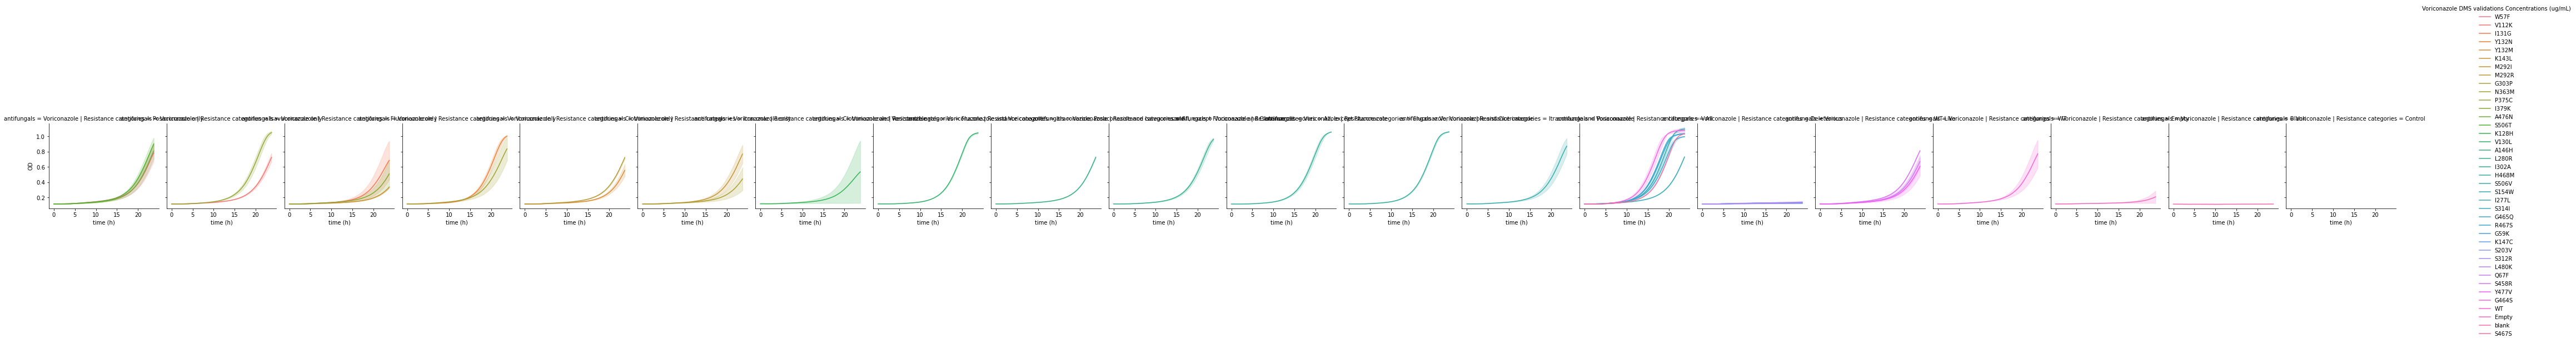

In [26]:
##Growth curves visualisation, the columns will be the different strains and the colors the different concentrations
##It can take between 30 secondes to 5 minutes to load as there is a lot of data

grid = sns.FacetGrid(data=merged_df[merged_df['time (h)'] <= time], row = "antifungals",  row_order = [antifungal],col="Resistance categories", hue="strains")
#to see only one add col_order=["name"] in sns.FacetGrid
grid.map(sns.lineplot, 'time (h)', 'OD')
grid.set_axis_labels('time (h)', 'OD')
grid.add_legend(title = (name + ' Concentrations (ug/mL)'))
grid.fig.subplots_adjust(top=0.9)

axes = grid.axes.flatten()

name1 = "GrowthCurves_" + name + str(time) + "H_" + date  
plt.savefig(f"c:{name1}.png", format='png', dpi=300)

# AUC calculations

In [10]:
#Definition of the area under the curve (AUC) calculation, the calculation is made from the ODs
def get_auc(g):
    return np.trapz(g.OD)

In [11]:
##Add the AUC on the Df without ODs to limit the quatity of data we continue with
aucdf = merged_df[merged_df['time (h)'] <= time].groupby('well')[['OD']].apply(func=get_auc).reset_index(name='auc')
condensed_df = df.merge(right=aucdf, on=['well'])
condensed_df.head()

,strains,concentrations,well,antifungals,Resistance categories,auc
0,Empty,0.0,E11,None,Control,39.808855
1,Empty,0.0,E12,None,Control,12.547840
2,G464S,0.0,C11,None,Control,45.749220
3,G464S,0.0,C12,None,Control,47.464980
4,S458R,0.0,A11,None,Control,46.223350


# AUC visualisations

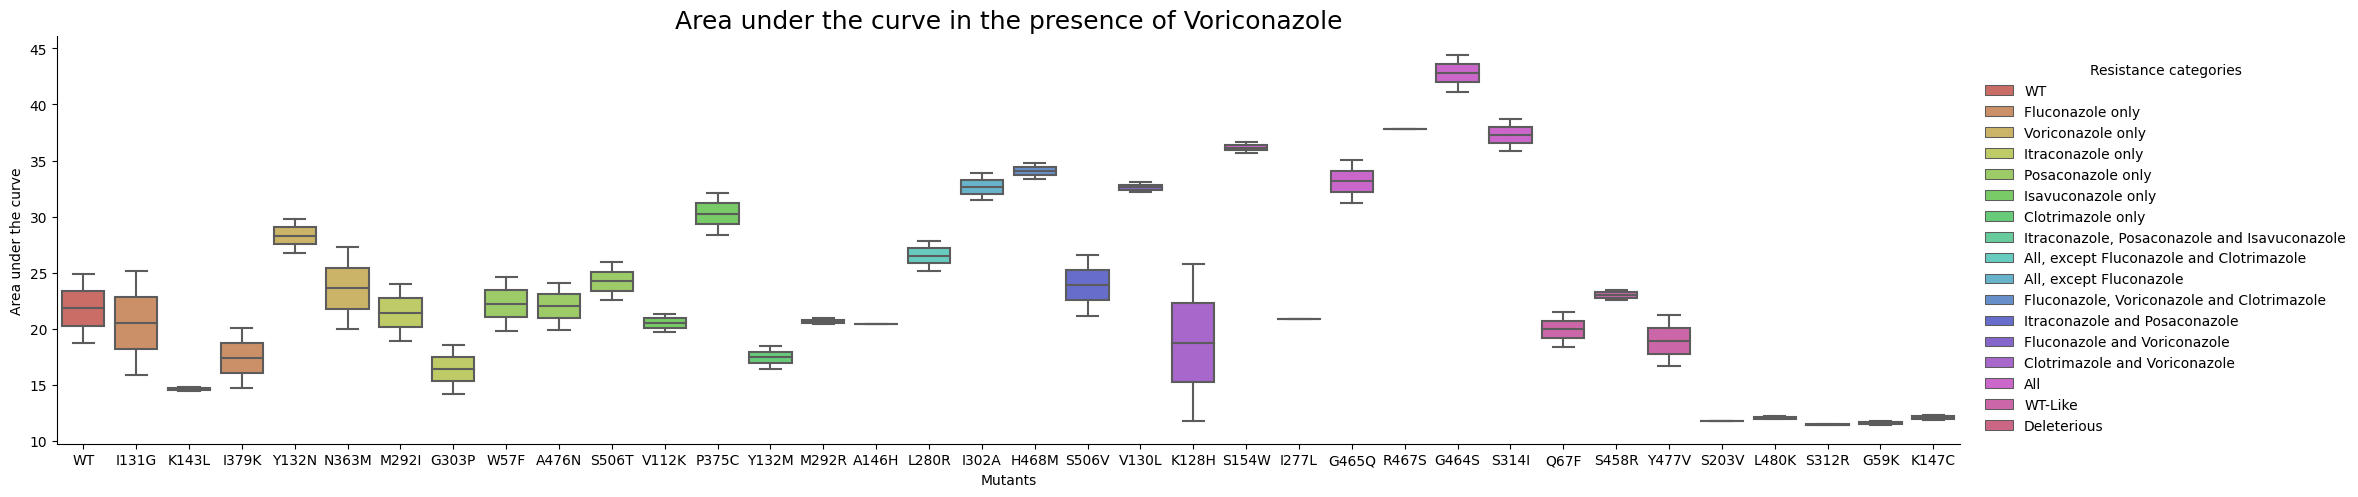

In [14]:
# Create the AUC boxplot

order = ["WT","I131G","K143L","I379K","Y132N","N363M","M292I","G303P","W57F","A476N","S506T","V112K","P375C",
                    "Y132M","M292R","A146H","L280R","I302A","H468M","S506V","V130L","K128H","S154W","I277L","G465Q",
                    "R467S","G464S","S314I","Q67F","S458R","Y477V","S203V","L480K","S312R","G59K","K147C"]

hue_order = ["WT",
    "Fluconazole only","Voriconazole only","Itraconazole only","Posaconazole only","Isavuconazole only","Clotrimazole only",   
    "Itraconazole, Posaconazole and Isavuconazole","All, except Fluconazole and Clotrimazole","All, except Fluconazole","Fluconazole, Voriconazole and Clotrimazole",
    "Itraconazole and Posaconazole", "Fluconazole and Voriconazole","Clotrimazole and Voriconazole","All", "WT-Like", "Deleterious"]

box = sns.catplot(x="strains", y="auc", col="antifungals", col_order=[antifungal],data=condensed_df, order=order, kind="box", hue = "Resistance categories",palette="hls",
                  height=5, aspect=4, hue_order=hue_order, dodge=False) 

box.set_axis_labels('Mutants', 'Area under the curve')

plt.title("Area under the curve in the presence of " + antifungal,size=18)

# Save the figure
name1 = "Boxplot_AUC_" + name + str(time) + "H_" + date
plt.savefig(f"c:{name1}.png", format='png', dpi=300)

plt.show()

In [16]:
#Save the data in an excel file if you want to work with it in an other software 
name1 = "Dataframe_AUC_" + name + str(time) + "H_" + date  
condensed_df.to_excel(f"c:{name1}.xlsx", index = False)

# Correlation with DMS selection coeffcient

In [17]:
condensed_df

,strains,concentrations,well,antifungals,Resistance categories,auc,dgr
0,Empty,0.00,E11,None,Control,39.808855,0.15460
1,Empty,0.00,E12,None,Control,12.547840,0.00332
2,G464S,0.00,C11,None,Control,45.749220,0.15428
3,G464S,0.00,C12,None,Control,47.464980,0.14132
4,S458R,0.00,A11,None,Control,46.223350,0.14220
...,...,...,...,...,...,...,...
91,blank,0.08,F10,Voriconazole,Blank,10.877880,0.00132
92,blank,0.08,G5,Voriconazole,Blank,10.796720,0.00204
93,blank,0.08,G10,Voriconazole,Blank,10.892635,0.00172
94,blank,0.08,H5,Voriconazole,Blank,10.752295,0.00180


In [18]:
# Filter rows where 'strains' is equal to 'blank' and calculate the mean of 'auc'
med_auc_blank = condensed_df[condensed_df['strains'] == 'blank']['auc'].median()

print("Median AUC for 'blank' strains:", med_auc_blank)

# Subtract the mean AUC of 'blank' from all 'auc' values
condensed_df['auc_noblank'] = condensed_df['auc'] - med_auc_blank

Median AUC for 'blank' strains: 10.8567675


In [19]:
condensed_df

,strains,concentrations,well,antifungals,Resistance categories,auc,dgr,auc_noblank
0,Empty,0.00,E11,None,Control,39.808855,0.15460,28.952088
1,Empty,0.00,E12,None,Control,12.547840,0.00332,1.691073
2,G464S,0.00,C11,None,Control,45.749220,0.15428,34.892453
3,G464S,0.00,C12,None,Control,47.464980,0.14132,36.608212
4,S458R,0.00,A11,None,Control,46.223350,0.14220,35.366582
...,...,...,...,...,...,...,...,...
91,blank,0.08,F10,Voriconazole,Blank,10.877880,0.00132,0.021112
92,blank,0.08,G5,Voriconazole,Blank,10.796720,0.00204,-0.060047
93,blank,0.08,G10,Voriconazole,Blank,10.892635,0.00172,0.035868
94,blank,0.08,H5,Voriconazole,Blank,10.752295,0.00180,-0.104472


In [20]:
s_df = pd.read_excel(select_coef_file, header=0, index_col=0)
s_df = s_df["s_vorico"]

# Subtract the mean AUC of 'blank' from all 'auc' values
condensed_df['auc_noblank'] = condensed_df['auc'] - med_auc_blank

condensed_df = condensed_df.loc[condensed_df['antifungals'] == "Voriconazole"]

condensed_df = condensed_df.merge(right=s_df, on=["strains"])
condensed_df = condensed_df.rename(columns={'s_vorico': 's'})

condensed_df["auc_noblank_log2"] = np.log2(condensed_df["auc_noblank"])
condensed_df['auc_noblank_log2_norm'] = condensed_df['auc_noblank_log2'] / condensed_df.loc[condensed_df['strains'] == 'WT', 'auc_noblank_log2'].mean()

#Save the data in an excel file if you want to work with it in an other software 
name1 = "Dataframe_blank_auc_s_replicates_" + name + str(time) + "H_" + date  
condensed_df.to_excel(f"c:{name1}.xlsx", index = False)
condensed_df

,strains,concentrations,well,antifungals,Resistance categories,auc,dgr,auc_noblank,s,auc_noblank_log2,auc_noblank_log2_norm
0,A146H,0.08,A3,Voriconazole,"Itraconazole, Posaconazole and Isavuconazole",20.412470,0.12488,9.555702,0.058961,3.256362,0.959274
1,A146H,0.08,A8,Voriconazole,"Itraconazole, Posaconazole and Isavuconazole",20.392735,0.12840,9.535967,0.058961,3.253379,0.958396
2,A476N,0.08,E2,Voriconazole,Posaconazole only,19.915685,0.12648,9.058917,0.011568,3.179339,0.936584
3,A476N,0.08,E7,Voriconazole,Posaconazole only,24.119305,0.13348,13.262537,0.011568,3.729285,1.098590
4,G303P,0.08,A2,Voriconazole,Itraconazole only,14.227270,0.03960,3.370503,-0.125684,1.752964,0.516396
...,...,...,...,...,...,...,...,...,...,...,...
66,Y132M,0.08,E6,Voriconazole,Clotrimazole only,18.453845,0.11992,7.597078,0.013986,2.925445,0.861791
67,Y132N,0.08,D1,Voriconazole,Voriconazole only,29.799195,0.13820,18.942427,0.209088,4.243549,1.250085
68,Y132N,0.08,D6,Voriconazole,Voriconazole only,26.754800,0.14024,15.898033,0.209088,3.990776,1.175621
69,Y477V,0.08,B5,Voriconazole,WT-Like,16.645115,0.08768,5.788348,0.024206,2.533152,0.746228


In [21]:
filtered_df = condensed_df.loc[condensed_df['antifungals'] == antifungal]
mean_df = filtered_df.groupby(["antifungals",'strains', 'Resistance categories'])[['auc',"auc_noblank"]].mean().reset_index()
mean_df

,antifungals,strains,Resistance categories,auc,auc_noblank
0,Voriconazole,A146H,"Itraconazole, Posaconazole and Isavuconazole",20.402603,9.545835
1,Voriconazole,A476N,Posaconazole only,22.017495,11.160727
2,Voriconazole,G303P,Itraconazole only,16.402275,5.545507
3,Voriconazole,G464S,All,42.784518,31.927750
4,Voriconazole,G465Q,All,33.136375,22.279608
5,Voriconazole,G59K,Deleterious,11.580770,0.724002
6,Voriconazole,H468M,"Fluconazole, Voriconazole and Clotrimazole",34.064940,23.208172
7,Voriconazole,I131G,Fluconazole only,20.475858,9.619090
8,Voriconazole,I277L,All,20.877082,10.020315
9,Voriconazole,I302A,"All, except Fluconazole",32.673682,21.816915


In [22]:
s_df = pd.read_excel(select_coef_file, header=0, index_col=0)
s_df = s_df["s_vorico"]

In [23]:
merged_df = mean_df.merge(right=s_df, on=["strains"])
merged_df = merged_df.rename(columns={'s_vorico': 's'})
merged_df

,antifungals,strains,Resistance categories,auc,auc_noblank,s
0,Voriconazole,A146H,"Itraconazole, Posaconazole and Isavuconazole",20.402603,9.545835,0.058961
1,Voriconazole,A476N,Posaconazole only,22.017495,11.160727,0.011568
2,Voriconazole,G303P,Itraconazole only,16.402275,5.545507,-0.125684
3,Voriconazole,G464S,All,42.784518,31.927750,0.323454
4,Voriconazole,G465Q,All,33.136375,22.279608,0.241385
5,Voriconazole,G59K,Deleterious,11.580770,0.724002,-0.559551
6,Voriconazole,H468M,"Fluconazole, Voriconazole and Clotrimazole",34.064940,23.208172,0.206330
7,Voriconazole,I131G,Fluconazole only,20.475858,9.619090,-0.011674
8,Voriconazole,I277L,All,20.877082,10.020315,0.346180
9,Voriconazole,I302A,"All, except Fluconazole",32.673682,21.816915,0.167022


In [24]:
#Save the data in an excel file if you want to work with it in an other software 
name1 = "Dataframe_blank_auc_s_" + name + str(time) + "H_" + date  
merged_df.to_excel(f"c:{name1}.xlsx", index = False)

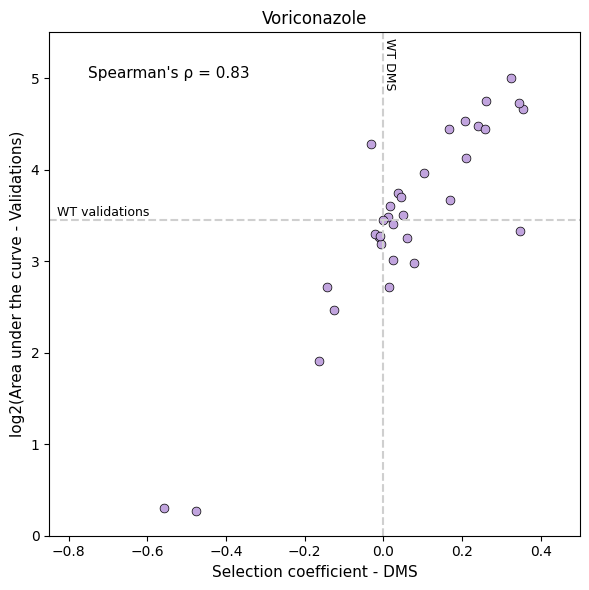

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))

# Log2 transform the "auc" column
merged_df["auc_no_blank_log2"] = np.log2(merged_df["auc_noblank"])

sns.scatterplot(y=merged_df["auc_no_blank_log2"], x=merged_df["s"], edgecolor="black", s=40,color = "#C1A4DE")

result = sp.stats.spearmanr(merged_df["auc_no_blank_log2"], merged_df["s"])
coeff = result[0]
p_value = "{:.1e}".format(result[1])
R2 = coeff**2

plt.axhline(y=np.log2(10.953332), linestyle='--', color='#CFCFCF')  # Log2 transform the y-coordinate
plt.axvline(x=0, linestyle='--', color='#CFCFCF')

#plt.ylim(np.log2(5), np.log2(60))  # Set y-axis limits to log2 values
plt.xlim(-0.85, 0.5)
plt.ylim(0, 5.5)

plt.ylabel("log2(Area under the curve - Validations)", fontsize=11)
plt.xlabel("Selection coefficient - DMS", fontsize =11)

plt.title(antifungal, fontsize=12)

text = "Spearman's ρ = " + str(round(coeff, 2))
plt.text(-0.75, 5, text, fontsize=11)  # Log2 transform the y-coordinate

plt.text(-0.83, np.log2(11.3), "WT validations", fontsize=9)  # Log2 transform the y-coordinate
plt.text(0, 4.9, "WT DMS", fontsize=9, rotation=-90)  # Log2 transform the y-coordinate

#plt.legend(title='Resistance categories', bbox_to_anchor=(1.05, 1), loc='upper left')

#for i, row in merged_df.iterrows():
    #plt.text(row['s_fluco'], row['auc'], row['strains'], fontsize=8, ha='center', va='bottom')

name1 = "Correlation_with_select_coef_log2_" + name + str(time) + "H_" + date  
plt.savefig(f"c:{name1}.png", format='png', dpi=300)

fig.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'

name1 = "Correlation_with_select_coef_auc_log2_" + name + str(time) + "H_" + date  
plt.savefig(f"c:{name1}.png", format='png', transparent=True,dpi=300)
plt.savefig(f"c:{name1}.svg", format='svg', transparent=True,dpi=300)
plt.show()